In [1]:
# Imports and util
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import re

class ImageData:

    def __init__(self, name) -> None:
        self.name = name
        self.run_dfs = {}
        self.norm_dfs = {}

## Step 1: Running energy tests <a id='energy'></a> 
The first step to studying the performance of a workload is to run energy experiments and find energy consumption differences or hotspots. We recommend using the docker-energy framework available [here](https://github.com/enriquebarba97/docker-energy) to run these energy experiments. This fork includes some modifications to print timestamps to the logs, that we later use in analysis.

For a workload, you should create a workload folder with multiple Dockerfiles, a docker-compose.yml and a config, with varying dependencies. In our example, we changed the base image, but other dependencies can be changed.

In [2]:
workload = "redis-server"

data_path = f"data/{workload}/energy"

images = next(os.walk(data_path))[1]

print(images)

['alpinemusl@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'light@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'centos@sha256a1801b843b1bfaf77c501e7a6d3f709401a1e0c83863037fa3aab063a7fdb9dc', 'debian@sha25660774985572749dc3c39147d43089d53e7ce17b844eebcf619d84467160217ab', 'ubuntu@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'alpinejem@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'ltrace@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpine@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpinepack@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpineglibc@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'ubuntupack@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'ubuntulibc@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020']


In [3]:
# Optionally select which images to plot
toplot = ["ubuntu","alpinepack", "alpineglibc"]

In [31]:
def energy_data(images, toplot=None, indices=None, xlim=None, ylim=None):
    dataframes = {}

    fig, ax = plt.subplots(figsize=[20,12])
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    data = {"Image": [], "Time (s)": [], "Energy (J)": []}

    for image in images:
        image_name = image.split("@")[0]
        # if image_name not in ["light", "node", "centos","debian"]:
        if toplot is None or len(toplot)==0 or image_name in toplot:
        # if image_name in ["ubuntu", "ubuntupack", "alpinepack", "alpinemusl", "alpineglibc", "alpinejem"]:    
            dataframes[image_name] = ImageData(image_name)
            image_path = os.path.join(data_path, image)
            files = next(os.walk(image_path))[2]
            files = [f for f in files if f.endswith(".tsv")]
            dfs = {file.split(".")[0]: pd.read_csv(os.path.join(image_path, file), usecols=["Delta", "Time", "CORE0_ENERGY (J)", "USED_MEMORY", "CPU_USAGE_0"]) for file in files}
            dataframes[image_name].run_dfs = dfs

            all_data = []
            for run in dfs:
                df = dfs[run]

                key = "PACAKGE_ENERGY (W)"
                if "CPU_ENERGY (J)" in df.columns:
                    key = "CPU_ENERGY (J)"
                if "CORE0_ENERGY (J)" in df.columns:
                    key = "CORE0_ENERGY (J)"
                if "PACKAGE_ENERGY (J)" in df.columns:
                    key = "PACKAGE_ENERGY (J)"
                if "SYSTEM_POWER (Watts)" in df.columns:
                    key = "SYSTEM_POWER (Watts)"

                # Collect total energy for violin plots
                if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
                    df["Point"] = np.arange(df.shape[0])
                    data["Image"].append(image_name)
                    data["Time (s)"].append((df["Time"].iloc[-1] - df["Time"].iloc[0])/1000)
                    data["Energy (J)"].append(df[key].iloc[-1] - df[key].iloc[0])

                # Compute power and plot
                energy = df[key].copy().to_list()
                cpu_data = df["CPU_USAGE_0"].copy().to_list()
                memory_data = df["USED_MEMORY"].copy().to_list()
                
                current_data = []

                if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
                    df[key + "_original"] = df[key].copy()
                    for i in range(0, len(energy)):
                        if i in df[key + "_original"] and i - 1 in df[key + "_original"]:
                            # diff with previous value and convert to watts
                            energy[i] = (energy[i] - df[key + "_original"][i - 1]) * (1000 / df["Delta"][i])
                        else:
                            energy[i] = 0
                    # data = data[1:-1]
                    for i in range(0, len(energy)):
                        current_data.append({"Time": i, "CPU_POWER (Watts)": energy[i], "CPU_USAGE_0": cpu_data[i], "USED_MEMORY": memory_data[i]})
                        all_data.append({"Time": i, "CPU_POWER (Watts)": energy[i], "CPU_USAGE_0": cpu_data[i], "USED_MEMORY": memory_data[i]})
            
                dataframes[image_name].norm_dfs[run] = pd.DataFrame(current_data)
            
            all_data = pd.DataFrame(all_data)
            dataframes[image_name].norm_dfs["median"] = all_data.groupby("Time").median().reset_index()
            
            plot = sns.lineplot(all_data, x="Time", y="CPU_POWER (Watts)", estimator=np.median,errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)), ax=ax, legend=True, label=image_name)
            
            if indices is not None:
                for index in indices:
                    ax.axvline(x=index, color='r', linestyle='--')

            ax.set_xlabel("Time", size=16) 
            ax.set_ylabel("CPU Power (W)", size=16)
            plot.set_title("redis-server")

    plt.show()
    return dataframes, pd.DataFrame(data)

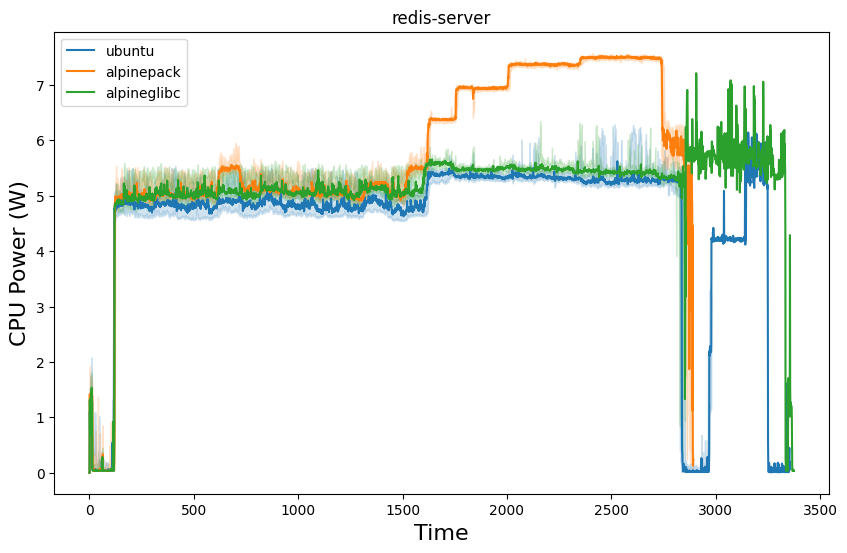

In [5]:
dataframes, aggregate = energy_data(images, toplot)

In [6]:
aggregate.groupby("Image").describe(include="all")

Time (s)                                                        
               count        mean        std      min        25%       50%   
Image                                                                       
alpineglibc     30.0  284.163933  10.206018  278.949  281.24900  282.3990  \
alpinepack      30.0  286.535233   1.347058  284.152  285.57500  286.4015   
ubuntu          30.0  295.271433   7.954821  288.177  293.12575  294.1805   

                                Energy (J)                           
                   75%      max      count         mean        std   
Image                                                                
alpineglibc  283.47725  337.589       30.0  1435.277323  24.093821  \
alpinepack   287.40500  289.353       30.0  1651.107956  15.555502   
ubuntu       295.57650  335.701       30.0  1401.535518  32.811963   

                                                                              
                     min          25%          50%          75%          max  
Image                                                                         
alpineglibc  1395.170670  1422.231220  1436.256866  1446.272015  1527.899826  
alpinepack   1622.637558  1644.226643  1650.471428  1657.752132  1702.232361  
ubuntu       1340.059143  1382.077553  1399.722046  1419.141323  1481.168533

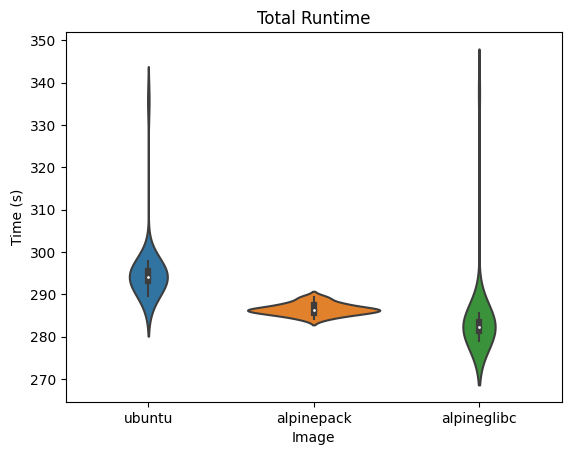

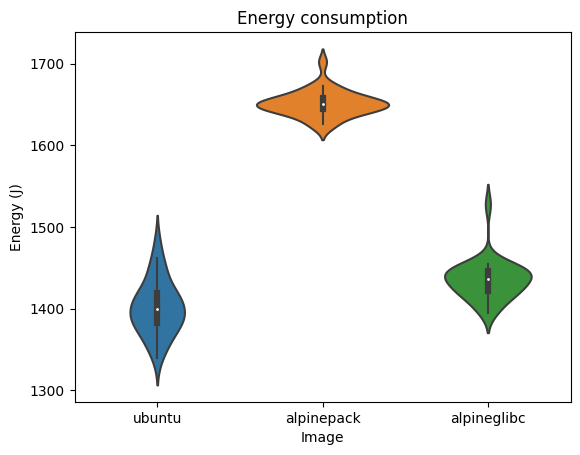

In [7]:
sns.violinplot(x="Image", y="Time (s)", data=aggregate)
plt.title("Total Runtime")
plt.show()

sns.violinplot(x="Image", y="Energy (J)", data=aggregate)
plt.title("Energy consumption")
plt.show()

## Step 2: Tracing with uftrace <a id='tracing'></a> 
The next step is to run the workload with *uftrace*. For this, it is recommended again to use docker. One of the Dockerfiles from the previous step can be reused by adding the installation steps of *uftrace* before the rest of the setup.

It is important to use the *ts* tool from [moreutils](https://joeyh.name/code/moreutils/) to have timestamps in the log that are consistent with the logs from docker-energy.

An example with redis is included in `docker/redis-traced`. You can use this as a template for your own tracing experiment. To run, use:

```
docker compose -f docker/redis-traced/docker-compose.yml build
docker compose -f docker/redis-traced/docker-compose.yml up --abort-on-container-exit 2>&1 | ts %.s > ./data/redis-server/logs/traced.txt
```

This will create the tracing data folder and the log file to use later during analysis

## Step 3: Trace analysis <a id='trace-analysis'></a> 
You can use the newly generated uftrace data folder to analyze some of the aspects of the workload execution. For example, you can use *uftrace report* to obtain general stats about function usage.

To keep using this notebook, you will need to use the *uftrace* fork available [here](https://github.com/enriquebarba97/uftrace), which increases the resolution of the time units displayed on some of the commands.

The replay of the calls realized during the workload can be seen with *uftrace replay*. This notebook uses the output of this command with the modified timestamp format. To obtain the necessary file, run:

```
uftrace replay -d {dir} -f rawElapsed,rawDuration > tracing.log
```

### Finding checkpoints
To find checkpoints in the logs, and the equivalent lines in the tracing, the following files are necessary:

- The log file from one of the runs of the energy experiment
- The energy data CSV from the equivalent run
- The log file of the tracing run

The reference run from the energy experiment can be chosen manually

In [8]:
# Utility code for cleaning and loading trace data
toRemove = [
  "[0-9]{10}\.[0-9]{6}",
  "(\d{1,4})(-|\/| )(\d{1,2})(-|\/| )(\d{1,4})( |T)?",
  "(\d{1,2}):(\d{1,2}):(\d{1,2})((\.|\+|,)(\d{1,7})Z?)?( (PM|AM|pm|am))?( [A-Z]{3})?",
  ".{3},?( .{3})? +(\d{1,2})( +.{3})?( |,)+(\d{1,4})",
  "\((\d+)\/(\d+)\)",
  "(\@|\$\$)[0-9a-z]+(\:|{|,|]| )",
  "[0-9a-fA-F]{8}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{12}",
  "(\d{5,})",
  "([0-9a-f]{10,})",
  "\d+:\d+ min",
  "(-->) +(\d+)%",
  "([\d\.]+)m?s",
  "([\d\.]+)m?illiseconds",
  "([0-9\.]+)M=0s",
  "([0-9\,\.]+) ?(kb|mb|m|b)(\/s)?",
  "([0-9\.]+) (seconds|secs|s|sec)",
  "(▉|█|▋)+",
  "={3,}>? *",
  "(\[|\|)\d+\/\d+(\]||\|)",
  "(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})",
  "\d{1,2} ?%",
]

class Trace:

    def __init__(self, path, tool="uftrace"):
        self.path = path
        filename = os.path.basename(self.path)
        dir = os.path.dirname(self.path)
        self.filename = os.path.splitext(filename)[0]
        self.csv = os.path.join(dir, self.filename + ".csv")
        self.line_count = self.count_lines()
        self.tool = tool
    
    def _count_generator(self, reader):
        b = reader(1024 * 1024)
        while b:
            yield b
            b = reader(1024 * 1024)

    def count_lines(self):
        with open(self.path, "rb") as file:
            c_generator = self._count_generator(file.raw.read)
            # count each \n
            count = sum(buffer.count(b'\n') for buffer in c_generator)
            return count + 1
        
    def compute_summary(self):

        self.fun_dict = {}
        durations = {}
        i = 0
        # Find the index of the first open parenthesis
        with open(self.path, "r") as file:
            for line in file:
                strs = line.split()

                fun_info = strs[2]

                index = fun_info.find("(")
                if index == -1:
                    continue
                fun = fun_info[:index]
                if fun not in self.fun_dict:
                    self.fun_dict[fun] = 1
                else:
                    self.fun_dict[fun] += 1

                start_duration = line.find("<")
                end_duration = line.find(">")
                if start_duration == -1 or end_duration == -1:
                    continue
                duration = line[start_duration + 1:end_duration]
                
                try:
                    if fun not in durations:
                        durations[fun] = [float(duration)]
                    else:
                        durations[fun].append(float(duration))
                except ValueError:
                    continue

                # Print progress
                if i % 100000 == 0:
                    print(i)
                i += 1
        
        # Convert each list of durations to a pandas series
        for key in durations:
            durations[key] = pd.Series(durations[key])
        
        self.durations = durations
        
    def plot(self):
        
        dict = {"Time": np.zeros(self.line_count, dtype=np.float64), "Function": np.zeros(self.line_count, dtype='U50'), "Duration": np.zeros(self.line_count, dtype=np.float64)}

        with open(self.path, "r") as file:
            for num, line in enumerate(file):

                if num % 100000 == 0:
                    print(num)

                strs = line.split()

                if len(strs) < 3:
                    continue

                try:
                    current_ts = float(strs[1])
                except ValueError:
                    continue
                
                fun_info = strs[2]

                index = fun_info.find("(")
                if index == -1:
                    continue
                fun = fun_info[:index]

                start_duration = line.rfind("<")
                end_duration = line.rfind(">")
                if start_duration == -1 or end_duration == -1:
                    continue
                duration = line[start_duration + 1:end_duration]
                
                try:
                    dict["Time"][num] = current_ts
                    dict["Function"][num] = fun
                    dict["Duration"][num] = float(duration)
                except ValueError:
                    dict["Time"][num] = 0
                    dict["Function"][num] = ""
                    dict["Duration"][num] = 0
                    continue

                #self.time_count.loc[num] = [current_ts, fun]
        
        # Remove 0 elements from arrays
        dict["Time"] = dict["Time"][dict["Time"] != 0]
        dict["Function"] = dict["Function"][dict["Function"] != ""]
        dict["Duration"] = dict["Duration"][dict["Duration"] != 0]

        self.trace_data = pd.DataFrame(dict)
        self.trace_data["Time"] = pd.to_datetime(self.trace_data["Time"], unit="s")
        
        self.trace_data = self.trace_data.groupby([trace.trace_data['Time'].dt.floor('100ms'), 'Function']).count().rename(columns={"Time":"count"}).reset_index()
    

    def process_ltrace(self, file, out):
        for num, line in enumerate(file):

            if num % 100000 == 0:
                print(num)

            strs = line.split()

            if len(strs) < 3:
                continue

            try:
                current_ts = float(strs[1])
            except ValueError:
                continue
                
            fun_info = strs[2]

            index = fun_info.find("(")
            if index == -1:
                continue
            fun = fun_info[:index]

            start_duration = line.rfind("<")
            end_duration = line.rfind(">")
            if start_duration == -1 or end_duration == -1:
                continue
            duration = line[start_duration + 1:end_duration]
                
            try:
                duration = float(duration)
            except ValueError:
                continue
                
            out.write(f"{current_ts},{fun},{duration}\n")
    
    def process_uftrace(self, file, out):
        print("Processing uftrace data")
        ongoing = ""
        ongoing_time = 0
        for num, line in enumerate(file):
            if num == 0:
                continue

            if num % 100000 == 0:
                print(num)

            # Remove character | from line
            line = line.replace("|", "")

            strs = line.split()

            if len(strs) < 3:
                print(strs)
                continue
            
            if len(strs) == 4 and strs[3] == "{":
                ongoing = strs[2].replace("(", "").replace(")", "").replace(";", "")
                ongoing_time = int(strs[1])
                continue

            try:
                duration = int(strs[0])
                elapsed = int(strs[1])
                fun = strs[2].replace("(", "").replace(")", "").replace(";", "")
                if fun == "}":
                    fun = ongoing
                    elapsed = ongoing_time
                    ongoing = ""
                    ongoing_time = 0
                
            except ValueError:
                continue

            out.write(f"{elapsed},{fun},{duration}\n")

    def to_csv(self):

        with open(self.path, "r") as file, open(self.csv, "w") as out:

            out.write("Time,Function,Duration\n")

            if self.tool == "uftrace":
                self.process_uftrace(file, out)
            else:
                self.process_ltrace(file, out)
            

    def load_data(self):
        # Check if csv exists
        if not os.path.exists(self.csv):
            self.to_csv()
        
        self.trace_data = pd.read_csv(self.csv, dtype={"Time": "int64", "Function": "string", "Duration": "uint16"})
        #self.trace_data["Time"] = pd.to_datetime(self.trace_data["Time"], unit="s")
            

def lines_to_dataframe(lines):
    dataframe = {"Line": [], "Progress": []}

    for i, line in enumerate(lines):
        line = line.strip()
        dataframe["Line"].append(line)
        dataframe["Progress"].append(i/len(lines))
    
    return pd.DataFrame(dataframe)

def get_relevant_lines(df, max_count=1, lower=0.01, upper=0.99):
    count = df["Line"].value_counts()
    unique_lines = df[~df["Line"].isin(count[count > max_count].index)].reset_index(names=["Line Number"])
    return unique_lines[(unique_lines["Progress"]>lower) & (unique_lines["Progress"]<upper)]

def remove_nums_line(line):
    return ''.join([i for i in line if not i.isdigit()])

def clean_line(line):
    for pattern in toRemove:
        line = re.sub(pattern, "", line)
    return line

def find_timestamp(lines, start):
    for j in range(start, len(lines)):
        line = lines[j]
        try:
            timestamp = line.split()[0]
            if re.match(r"[0-9]{10}\.[0-9]{6}", timestamp):
                timestamp = int(float(timestamp)*1e6)
                return timestamp
            elif re.match(r"[0-9]{10}", timestamp):
                timestamp = int(timestamp)*1e6
                return timestamp
        except IndexError:
            continue
    
    return None

In [9]:
reference_log_path = f"data/{workload}/logs/reference.txt"
tracing_log_path = f"data/{workload}/logs/traced.txt"
reference_data = pd.read_csv(f"data/{workload}/energy/reference.tsv", usecols=["Delta", "Time", "CORE0_ENERGY (J)", "USED_MEMORY", "CPU_USAGE_0"])

In [10]:
with open(reference_log_path, "r") as file:
    lines_ref = file.readlines()
    clean_lines = [clean_line(line) for line in lines_ref]

    df_lines = lines_to_dataframe(clean_lines)

    relevant_lines_ref = get_relevant_lines(df_lines, max_count=1, lower=0.07, upper=0.95)

relevant_lines_ref

,Line Number,Line,Progress
97,245,PING_MBULK,0.070463
98,279,redis-server-client-1 | 0.0 <= illiseconds (c...,0.080242
99,300,redis-server-client-1 | throughput summary:...,0.086281
100,303,redis-server-client-1 | 0.272 0.0...,0.087144
101,305,SET: rps=.0 (overall: .0) avg_msec=0.275 (over...,0.087719
...,...,...,...
1097,3247,LRANGE_600 (first 600 elements): rps=.4 (overa...,0.933851
1098,3249,LRANGE_600 (first 600 elements),0.934426
1099,3285,redis-server-client-1 | 0.0 <= illiseconds (c...,0.944780
1100,3288,redis-server-client-1 | 1.8 <= illiseconds (c...,0.945643


In [11]:
with open(tracing_log_path, "r") as file:

    lines_traced = file.readlines()
    clean_lines = [clean_line(line) for line in lines_traced]

    df_lines = lines_to_dataframe(clean_lines)

    min_time = find_timestamp(lines_traced, 0)

    relevant_lines_traced = get_relevant_lines(df_lines, max_count=1, lower=0.07, upper=0.95)

relevant_lines_traced

,Line Number,Line,Progress
44,138,client-1 | 0.1 <= illiseconds (cumulative...,0.083133
45,139,client-1 | 0.5 <= illiseconds (cumulative...,0.083735
46,140,client-1 | 1.3 <= illiseconds (cumulative...,0.084337
47,141,client-1 | 3.6 <= illiseconds (cumulative...,0.084940
48,142,client-1 | 15.6 <= illiseconds (cumulativ...,0.085542
...,...,...,...
447,1553,client-1 | 46.1 <= illiseconds (cumulativ...,0.935542
448,1554,client-1 | 67.1 <= illiseconds (cumulativ...,0.936145
449,1555,client-1 | 81.1 <= illiseconds (cumulativ...,0.936747
450,1556,client-1 | 88.8 <= illiseconds (cumulativ...,0.937349


In [12]:
# Intersection of relevant lines
relevant_lines = relevant_lines_ref[relevant_lines_ref["Line"].isin(relevant_lines_traced["Line"])]
relevant_lines["Line Number Trace"] = [relevant_lines_traced[relevant_lines_traced["Line"] == line]["Line Number"].values[0] for line in relevant_lines["Line"]]
relevant_lines

/tmp/ipykernel_12475/2673121901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_lines["Line Number Trace"] = [relevant_lines_traced[relevant_lines_traced["Line"] == line]["Line Number"].values[0] for line in relevant_lines["Line"]]


,Line Number,Line,Progress,Line Number Trace
140,387,SET,0.111303,181
183,525,GET,0.150992,255
222,663,INCR,0.190682,324
269,809,LPUSH,0.232672,400
312,954,RPUSH,0.274374,474
354,1090,LPOP,0.313489,547
399,1231,RPOP,0.354041,618
439,1372,SADD,0.394593,683
484,1512,HSET,0.434858,750
530,1656,SPOP,0.476273,822


In [13]:
# %%
checkpoints_ref = []
checkpoints_trace = []

for i in relevant_lines.index:
    start_ref = relevant_lines["Line Number"][i]
    start_trace = relevant_lines["Line Number Trace"][i]
    
    timestamp = find_timestamp(lines_ref, start_ref)
    if timestamp is not None:
        checkpoints_ref.append((lines_ref[start_ref], timestamp/1000, relevant_lines["Progress"][i]))
    
    timestamp = find_timestamp(lines_traced, start_trace)
    if timestamp is not None:
        checkpoints_trace.append((lines_traced[start_trace], timestamp - min_time, relevant_lines["Progress"][i]))

In [14]:
# Find indices of reference checkpoints from the original power lineplot

size = reference_data.shape[0]

indices = []
indices_progress = []
for checkpoint in checkpoints_ref:
    index = reference_data[reference_data["Time"] > checkpoint[1]].index[0]
    if index not in indices:
        indices.append(index)
    
    indices_progress.append(int(checkpoint[2]*size))

if len(indices) < len(checkpoints_ref):
    indices = indices_progress


In [15]:
trace = Trace(os.path.abspath(f"data/{workload}/tracing/tracing.log"))
trace.load_data()

In [17]:
left = trace.trace_data["Time"].iloc[0]
rel_left = 0
max_time = reference_data.shape[0]

runtimes = pd.DataFrame(columns=["Function", "Time", "Duration"])

for i in range(len(checkpoints_trace) + 1):
    if i == len(checkpoints_trace):
        right = trace.trace_data["Time"].iloc[-1]
        rel_right = max_time
    else:

        right = checkpoints_trace[i][1]*1e3
        rel_right = indices[i]

    # slice = filtered[(filtered["Time"]>=left) & (filtered["Time"]<right)]["Time"]
    # slice = (slice - left)/(right-left) * (rel_right-rel_left) + rel_left

    # filtered.loc[(filtered["Time"]>=left) & (filtered["Time"]<right), "Time"] = slice
    # left = right
    # rel_left = rel_right

    slice = trace.trace_data[(trace.trace_data["Time"]>=left) & (trace.trace_data["Time"]<right)]
    durations = slice.groupby("Function")["Duration"].sum().reset_index()
    durations["Time"] = rel_left
    durations = durations.sort_values("Duration", ascending=False).head(5)
    runtimes = pd.concat([runtimes, durations], ignore_index=True)

    left = right
    rel_left = rel_right

/tmp/ipykernel_12475/3924064766.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace.trace_data["Time"].iloc[-1] = max_time


In [20]:
# Filter out some of the less relevant functions, based on output from uftrace report
runtimes = runtimes[~runtimes["Function"].isin(["memset","close","strlen","pthread_mutex_trylock","pthread_mutex_unlock"])]

Text(0.5, 1.0, 'redis-server')

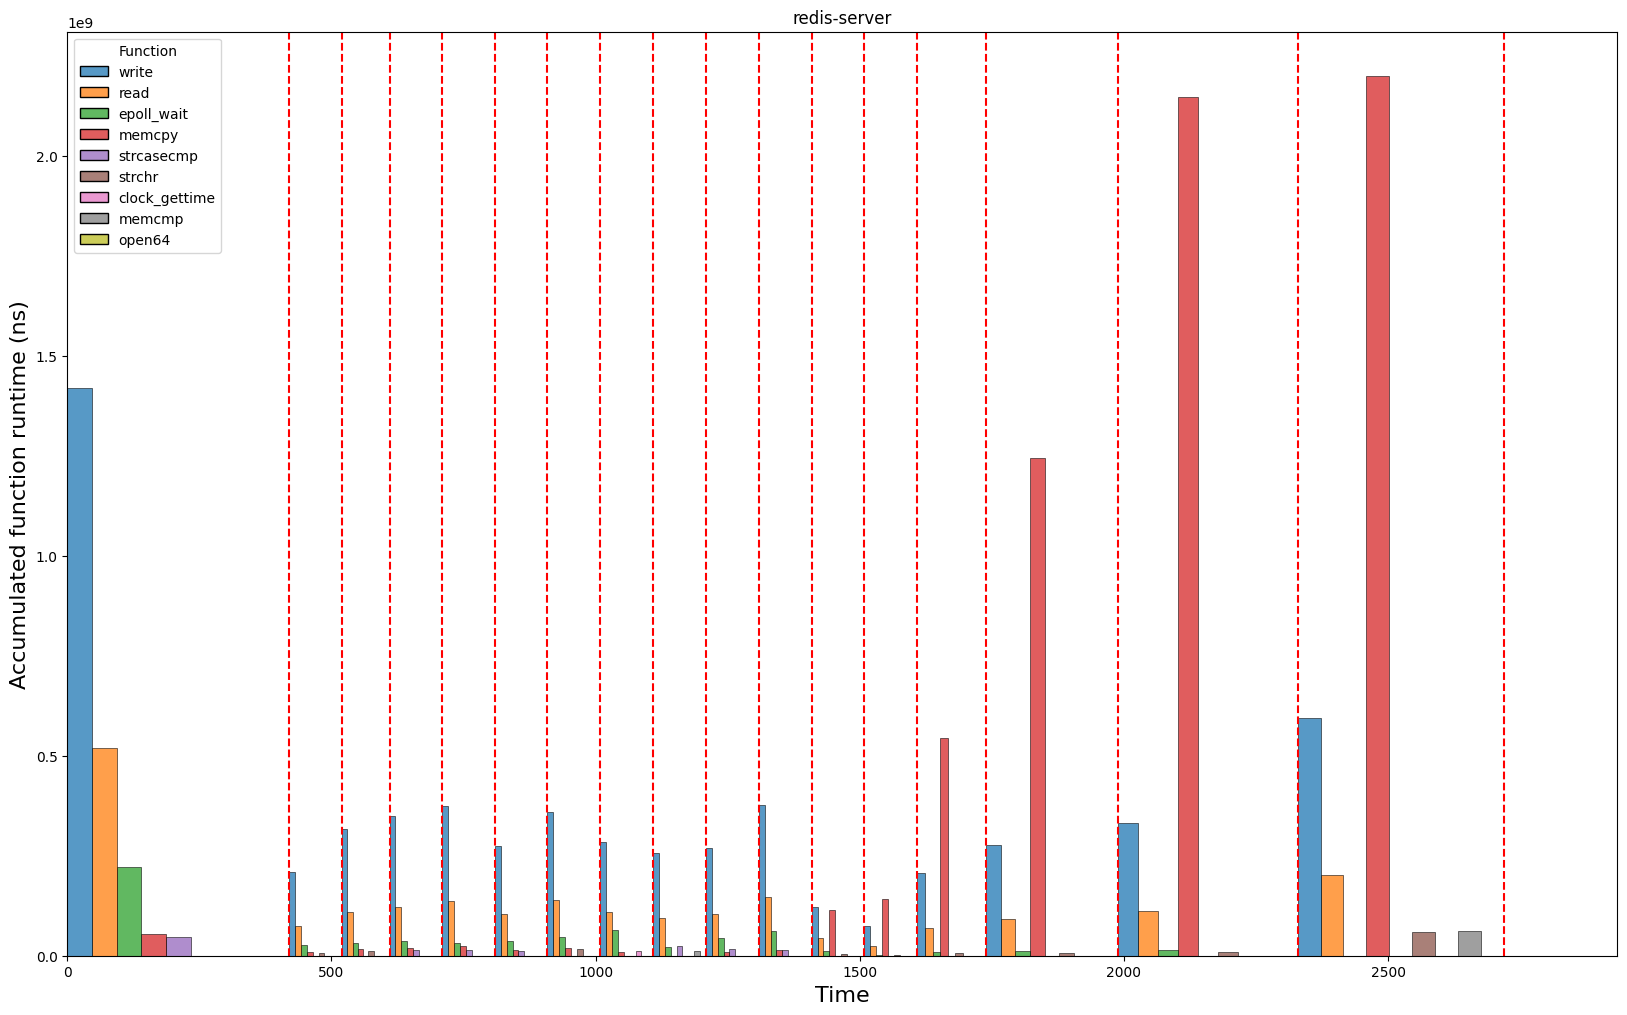

In [29]:
fig, ax = plt.subplots(figsize=[20,12])
ax.set_xlim(0, max_time)

bins = [0] + indices + [max_time]
sns.histplot(data=runtimes, x="Time", hue="Function", weights="Duration", multiple="dodge", bins=bins)

for index in indices:
    ax.axvline(x=index, color="red", linestyle="--")

ax.set_xlabel("Time", size=16)
ax.set_ylabel("Accumulated function runtime (ns)", size=16)
plt.title("redis-server")

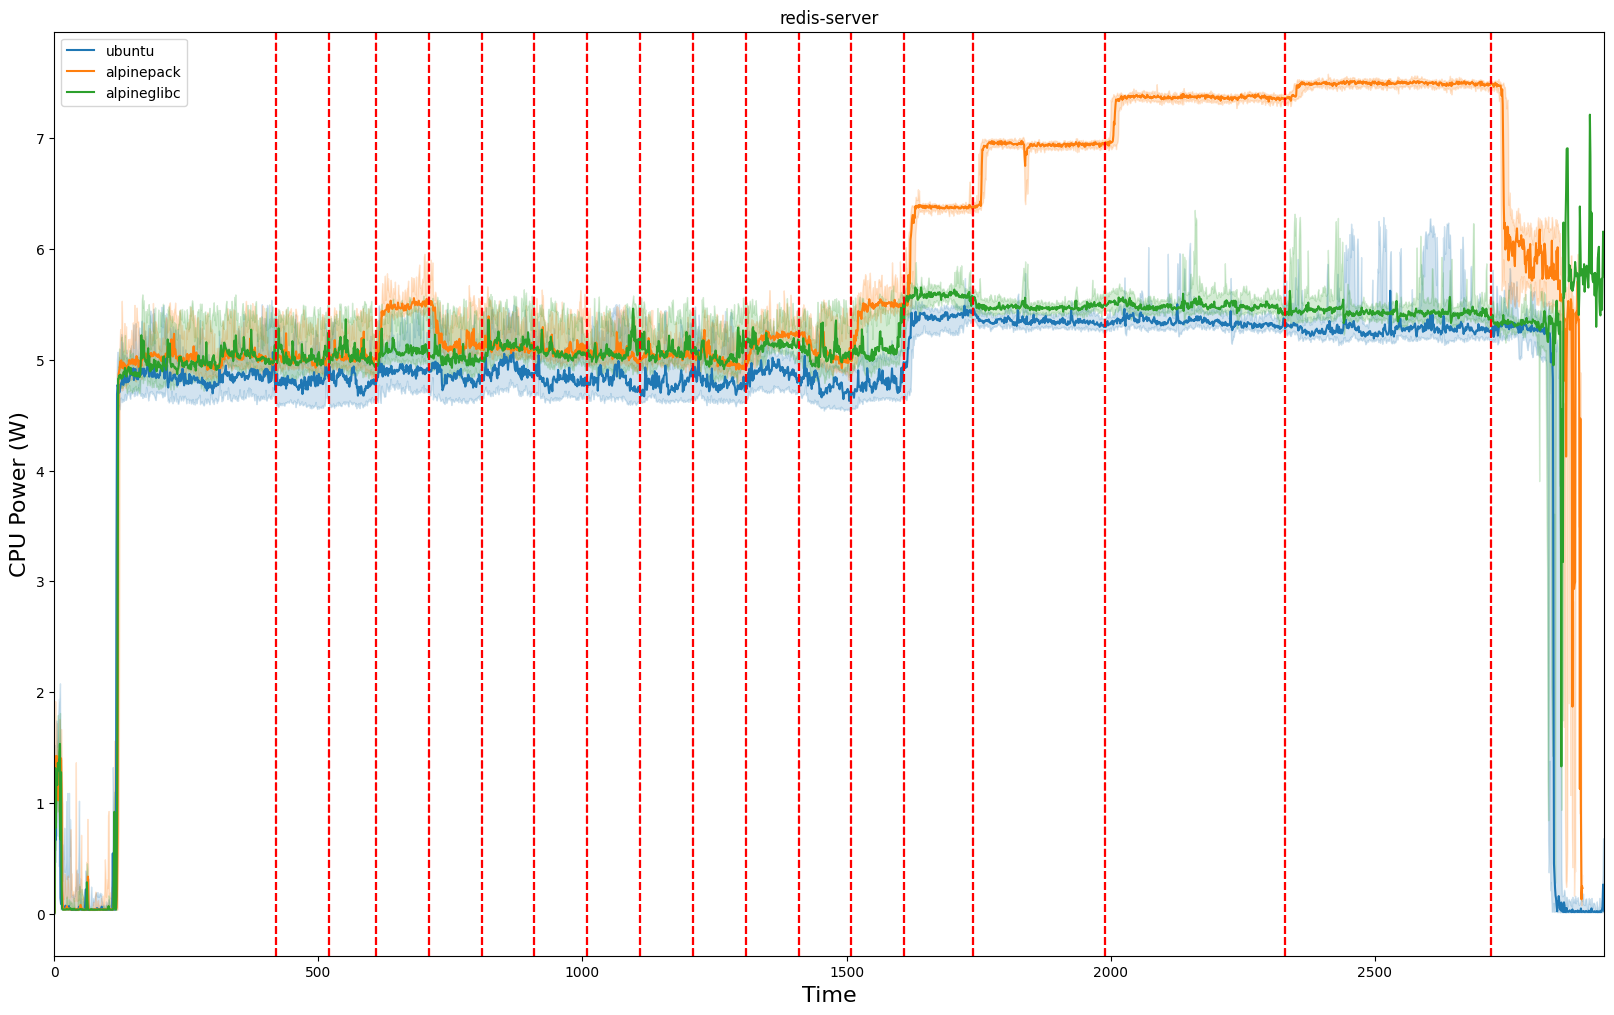

In [32]:
_,_ =energy_data(images, toplot, indices, xlim=(0, max_time))